# Face Detection Project

First of all, we import the GitHub repository containing the datasets and the script with some functions we will use:

In [1]:
!git clone https://github.com/Mat-Gug/face_detection_project.git

Cloning into 'face_detection_project'...
remote: Enumerating objects: 73047, done.
remote: Counting objects: 100% (29280/29280), done.
remote: Compressing objects: 100% (29279/29279), done.
remote: Total 73047 (delta 1), reused 29279 (delta 1), pack-reused 43767
Receiving objects: 100% (73047/73047), 2.03 GiB | 34.64 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (73042/73042), done.


As regards the feature extraction technique, we are going to use the **Histogram of Oriented Gradients (HOG) algorithm**, which transforms image pixels into a vector representation that works well also in presence of confounding factors like variations in illumination.

The idea is that of dividing the image into small connected regions called **cells**, and computing a histogram of the gradient orientations for the pixels within each cell. The descriptor is the concatenation of these histograms.

For improved accuracy, the local histograms can be contrast-normalized by calculating a measure of the intensity across a larger region of the image, called a **block**, and then using this value to normalize all cells within the block. This normalization results in better invariance to changes in illumination and shadowing.

Let's visualize the oriented gradients within each cell for an image containing a face:

Final image shape: (96, 96)


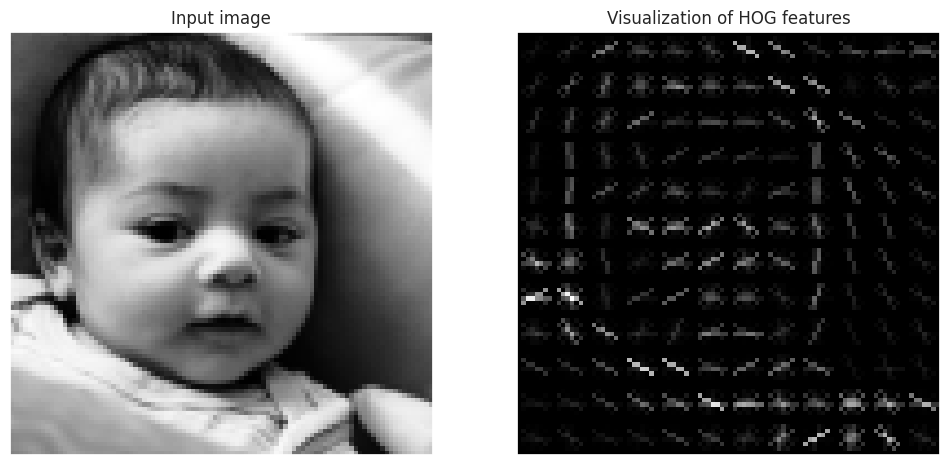

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from skimage import transform
from face_detection_project.utils import *

POS_PATH = '/content/face_detection_project/positive_images'
NEG_PATH = '/content/face_detection_project/negative_images'
RANDOM_SEED = 1

img = cv2.imread(os.path.join(POS_PATH, '00000.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.equalizeHist(img)
img = transform.rescale(img, 0.75)
hog_vec, hog_vis = feature.hog(img, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Input image')
ax[1].imshow(hog_vis, cmap="gray")
ax[1].set_title('Visualization of HOG features')
print(f"Final image shape: {img.shape}")

In [3]:
num_pos_images = count_elements_in_folder(POS_PATH)
num_neg_images = count_elements_in_folder(NEG_PATH)

print('Number of positive images:', num_pos_images)
print('Number of negative images:', num_neg_images)

Number of positive images: 70000
Number of negative images: 3019


Let's now create a numpy array for the images containing a face, randomly selecting 15500 positive images from the folder `positive_images`:

In [4]:
import os
import random

random.seed(RANDOM_SEED)
random_pos_elements = random.sample(os.listdir(POS_PATH), 15500)
n_pos_images = len(random_pos_elements)
positive_images = np.empty((n_pos_images, 96, 96))

for i, filename in enumerate(random_pos_elements):

    path = os.path.join(POS_PATH, filename)
    positive_images[i] = process_image(path, rescaling_factor=0.75)

Let's visualize some of them to get an idea of what they look like:

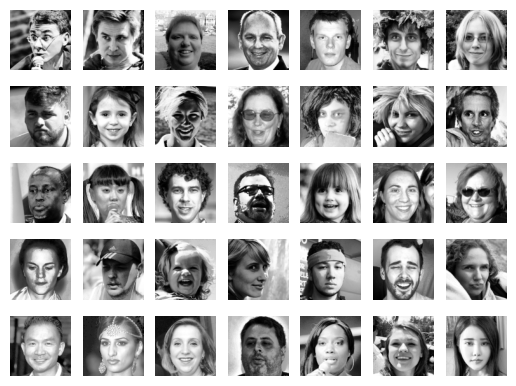

In [5]:
fig, ax = plt.subplots(5, 7)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_images[50 * i], cmap='gray')
    axi.axis('off')

We now do the same for the images without faces:

In [6]:
random.seed(RANDOM_SEED)
random_neg_elements = random.sample(os.listdir(NEG_PATH), 1550)
negative_patches = None

for filename in random_neg_elements:

  path = os.path.join(NEG_PATH, filename)

  img = read_and_convert(path)

  scales = [0.5, 1.0]
  ratio = (img.shape[0]/positive_images.shape[1],
           img.shape[1]/positive_images.shape[2])

  if min(ratio) >= 2:
    scales.extend([1.5,2.0])
  elif min(ratio) >= 1.5:
    scales.append(1.5)
  elif min(ratio) < 1:
    scales = [min(ratio)]

  if negative_patches is None:
    negative_patches = np.vstack([extract_patches(img,
                                                  3,
                                                  scale=scale,
                                                  patch_size=positive_images.shape[1:],
                                                  random_state=RANDOM_SEED) for scale in scales])
  else:
    new_patches = np.vstack([extract_patches(img,
                                             3,
                                             scale=scale,
                                             patch_size=positive_images.shape[1:],
                                             random_state=RANDOM_SEED) for scale in scales])
    negative_patches = np.vstack((negative_patches, new_patches))

negative_patches.shape

(18027, 96, 96)

We now have 18027 suitable image patches that do not contain faces. Let's take a look at a few of them to get an idea of what they look like:

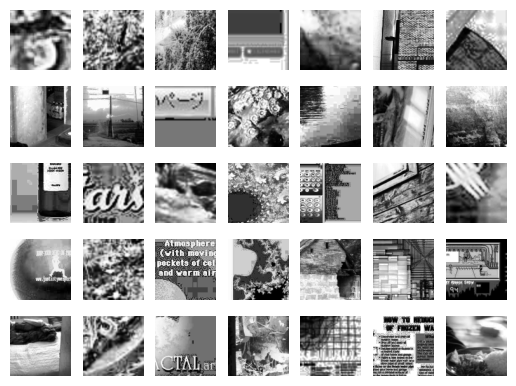

In [7]:
fig, ax = plt.subplots(5, 7)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[50 * i], cmap='gray')
    axi.axis('off')

Now that we have both positive and negative samples, we can combine them and compute HOG features. This step takes a little while, because the HOG features involve a non-trivial computation for each image:

In [8]:
from itertools import chain
from skimage import feature

X_train = np.array([feature.hog(im)
                    for im in chain(positive_images,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_images.shape[0]] = 1

In [9]:
X_train.shape

(33527, 8100)

Therefore, we have 33527 training samples and 8100 dimensions, which are in a form that can be used to train a Linear Support Vector Classifier. In particular, we search over specified parameter values of the regularization parameter `C`, choosing the value leading to the best accuracy:

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    LinearSVC(max_iter=5000),
    {'C': np.logspace(-5,2,num=8,base=10)},
    refit=True)
grid.fit(X_train, y_train)
grid.best_score_

0.9990455596099345

In [11]:
grid.best_params_

{'C': 0.01}

In [12]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=0.01, max_iter=5000)

Finally, we store the model into a file by using the `joblib` library:

In [13]:
import joblib
from google.colab import files

joblib.dump(model, 'my_model.joblib')
files.download('my_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We will use it to detect faces in the file `face-detection.ipynb`.